In [1]:
%matplotlib inline
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import random

Loading the Images
------------------

### crop

In [2]:
image = Image.open("./data/OneGog.png")

w, h = image.size
print(image.size)

(498, 389)


In [5]:
image.crop((0, 0, h, h)).save("./data/OneGogCrop.png")

### del alpha size

In [3]:
import numpy


def del_alpha(img):
    numpy_img = numpy.array(img)
    torch_img = torch.FloatTensor(numpy.delete(numpy_img, 3, 1))
    
    return torch_img

### load

In [4]:
imsize = 250

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()]) 


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return torch.FloatTensor(image)


style_img = del_alpha(image_loader("./data/OneGogCrop.png"))
content_img = del_alpha(image_loader("./data/MyPhoto1.png"))



print(style_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 250, 250])


### Show the picts

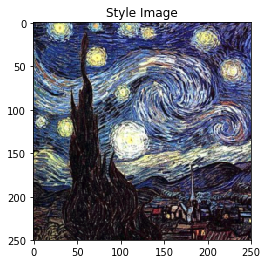

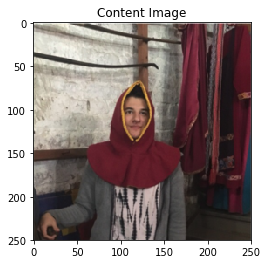

In [5]:
unloader = transforms.ToPILImage() 

def imshow(tensor, title=None):
    image = tensor.clone()  
    image = image.squeeze(0) # убираем размер батча
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

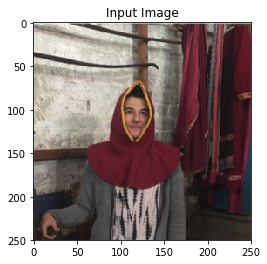

In [17]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

Loss Functions
--------------

In [7]:
# gram mtrx
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  # reshape

    G = torch.mm(features, features.t())  # gramm 
    # normalize
    return G.div(a * b * c * d)

In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Import Model
-------------------

In [10]:
cnn = models.vgg19(pretrained=True).features.eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

## add losses to model and crop


In [12]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [13]:
style_layers = [0, 2, 5, 7, 10]


normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)
model = nn.Sequential()

model.add_module('-1', normalization)
content_losses = []
style_losses = []

i = 0  
for layer in cnn.children():
    print(layer)
    if isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False)
    
    model.add_module(str(i), layer)
    
    if i == 7:
        target_feature = model(content_img).detach()
        content_loss = ContentLoss(target_feature)
        model.add_module('content_loss {}'.format(i), content_loss)
        content_losses.append(content_loss)
        
    if i in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module('style_loss {}'.format(i), style_loss)
        style_losses.append(style_loss)
        
    if i == 10:
        break
    
    i += 1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [14]:
model

Sequential(
  (-1): Normalization()
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 0): StyleLoss()
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 2): StyleLoss()
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 5): StyleLoss()
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss 7): ContentLoss()
  (style_loss 7): StyleLoss()
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 10): StyleLoss()
)

## Run the algorithm

In [15]:
num_steps = 300
style_weight = 100000 * 5
content_weight = 1

optimizer = optim.LBFGS([input_img.requires_grad_()])

run = [0]
while run[0] <= num_steps:
    

    def closure():
        input_img.data.clamp_(0, 1) 
        
        optimizer.zero_grad()
        model(input_img)
        style_score = 0 
        content_score = 0

        # Прибавляем лосс
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight
        
        run[0] += 1
        if run[0] % 30 == 0:
            print('run {}:\nStyle Loss : {:4f} Content Loss: {:4f}\n'.format(
                run, style_score.item(), content_score.item()))

        loss = style_score + content_score
        loss.backward()
       
        return style_score + content_score
      
    optimizer.step(closure)

input_img.data.clamp_(0, 1)

run [30]:
Style Loss : 344.486603 Content Loss: 49.306149

run [60]:
Style Loss : 76.965179 Content Loss: 47.855530

run [90]:
Style Loss : 35.679146 Content Loss: 44.916504

run [120]:
Style Loss : 23.353765 Content Loss: 41.470211

run [150]:
Style Loss : 15.814032 Content Loss: 38.034752

run [180]:
Style Loss : 10.912963 Content Loss: 35.550014

run [210]:
Style Loss : 8.759061 Content Loss: 32.972935

run [240]:
Style Loss : 7.047160 Content Loss: 30.873672

run [270]:
Style Loss : 5.913365 Content Loss: 29.049051

run [300]:
Style Loss : 5.046344 Content Loss: 27.653622



tensor([[[[0.8306, 0.5775, 0.3493,  ..., 0.3999, 0.6459, 0.7521],
          [0.4647, 0.5297, 0.6826,  ..., 0.4943, 0.4334, 0.5243],
          [0.4018, 0.6294, 0.5243,  ..., 0.4360, 0.2676, 0.2473],
          ...,
          [0.4336, 0.5724, 0.5044,  ..., 0.0616, 0.0696, 0.2091],
          [0.4665, 0.2210, 0.3065,  ..., 0.1245, 0.1427, 0.1366],
          [0.4898, 0.5876, 0.4940,  ..., 0.0117, 0.0237, 0.2758]],

         [[0.7655, 0.4033, 0.7792,  ..., 0.5087, 0.5450, 0.9935],
          [0.3746, 0.6499, 0.7139,  ..., 0.7862, 0.6364, 0.5029],
          [0.4980, 0.5364, 0.4983,  ..., 0.1896, 0.2918, 0.1516],
          ...,
          [0.0759, 0.5456, 0.2420,  ..., 0.0157, 0.0000, 0.0000],
          [0.3223, 0.5699, 0.3902,  ..., 0.0000, 0.0000, 0.0000],
          [0.3849, 0.6106, 0.4257,  ..., 0.0637, 0.0000, 0.1072]],

         [[0.8106, 0.7029, 0.5533,  ..., 0.5511, 0.6114, 0.9380],
          [0.7041, 0.5409, 0.6669,  ..., 0.6600, 0.5245, 0.3660],
          [0.4666, 0.7359, 0.6303,  ..., 0

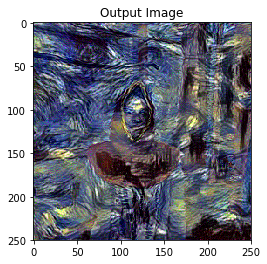

In [16]:
plt.figure()
imshow(input_img, title='Output Image')
plt.show()

## Correct style_weight

In [18]:
num_steps = 300
style_weight = 100000
content_weight = 1

optimizer = optim.LBFGS([input_img.requires_grad_()])

run = [0]
while run[0] <= num_steps:
    

    def closure():
        input_img.data.clamp_(0, 1) 
        
        optimizer.zero_grad()
        model(input_img)
        style_score = 0 
        content_score = 0

        # Прибавляем лосс
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight
        
        run[0] += 1
        if run[0] % 30 == 0:
            print('run {}:\nStyle Loss : {:4f} Content Loss: {:4f}\n'.format(
                run, style_score.item(), content_score.item()))

        loss = style_score + content_score
        loss.backward()
       
        return style_score + content_score
      
    optimizer.step(closure)

input_img.data.clamp_(0, 1)

run [30]:
Style Loss : 25.550856 Content Loss: 38.749058

run [60]:
Style Loss : 5.193034 Content Loss: 31.061422

run [90]:
Style Loss : 3.280789 Content Loss: 25.562784

run [120]:
Style Loss : 2.729578 Content Loss: 22.491667

run [150]:
Style Loss : 2.045216 Content Loss: 20.787090

run [180]:
Style Loss : 1.720752 Content Loss: 19.600876

run [210]:
Style Loss : 1.551446 Content Loss: 18.735107

run [240]:
Style Loss : 1.416884 Content Loss: 18.175842

run [270]:
Style Loss : 1.343354 Content Loss: 17.749130

run [300]:
Style Loss : 1.304137 Content Loss: 17.441027



tensor([[[[0.4341, 0.6636, 0.5059,  ..., 0.4057, 0.5546, 0.3883],
          [0.5938, 0.6125, 0.5327,  ..., 0.6533, 0.7458, 0.7276],
          [0.5059, 0.3640, 0.5756,  ..., 0.4605, 0.3764, 0.3191],
          ...,
          [0.2150, 0.3066, 0.1520,  ..., 0.0418, 0.1741, 0.0140],
          [0.5055, 0.2022, 0.2094,  ..., 0.1578, 0.2238, 0.0231],
          [0.6779, 0.2888, 0.1333,  ..., 0.0721, 0.1042, 0.1793]],

         [[0.4312, 0.7953, 0.6217,  ..., 0.4469, 0.5362, 0.2681],
          [0.7530, 0.6393, 0.5291,  ..., 0.9214, 0.9304, 0.8765],
          [0.3551, 0.4376, 0.6463,  ..., 0.2801, 0.2797, 0.5160],
          ...,
          [0.0001, 0.3690, 0.1611,  ..., 0.1459, 0.1122, 0.1395],
          [0.4530, 0.2148, 0.1312,  ..., 0.1319, 0.0969, 0.1445],
          [0.6614, 0.4534, 0.1045,  ..., 0.1521, 0.1278, 0.3028]],

         [[0.8378, 0.9735, 0.8311,  ..., 0.5924, 0.7142, 0.7296],
          [0.9501, 0.8145, 0.6843,  ..., 0.6367, 0.6179, 0.7224],
          [0.7393, 0.5401, 0.6131,  ..., 0

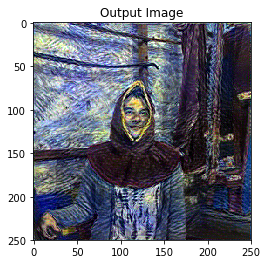

In [19]:
plt.figure()
imshow(input_img, title='Output Image')
plt.show()